# Math Dataset prediction sample

> You can contact me on twitter as [@mandubian](http://twitter.com/mandubian)

This notebook demonstrates some predictions using a pre-trained Transformer on Mathematical Reasoning Dataset v1.0 (arithmeric/add_sub/easy) as explained in this very cool paper:

> Analysing Mathematical Reasoning Abilities of Neural Models
>
> David Saxton, Edward Grefenstette, Felix Hill, Pushmeet Kohli
>
> (Submitted on 2 Apr 2019)
>
>http://arxiv.org/abs/1904.01557

**On top of paper, the current project provides a few Numpy/Pytorch helpers to manipulate Mathematical Reasoning Dataset in a simpler way and train very fast different kinds of models on it. Without loading everything in memory, it tries to manage data in a streamed and lazy-loading way (as much as Python allows it).**

The idea of the paper is to provide a robust toolkit (https://github.com/deepmind/mathematics_dataset) to randomly and heterogenously generate mathematical datasets among multiple math problem categories:
    - algebra
    - numbers
    - polynomials
    - arithmetic
    - measurement
    - comparison
    - probability
    - calculus
    
All problem are constituted of a textual question like `what is 30 + 535?` (max 160 chars) and a textual response `565` (max 30 chars). So it's not an abstract representation of math problem but a very human one and it mixes Natural Language Processing with math concepts.

For each of those categories, it provides multiple operation modules. For ex, in `algebra` category:
    - mul
    - add_or_sub_in_base
    - simplify_surd
    - mul_div_multiple
    - mixed
    - nearest_integer_root
    - div
    - add_or_sub
    - add_sub_multiple
    - add_sub_multiple_longer
    - mul_div_multiple_longer
    - div_big
    - mul_big
    - mixed_longer
    - add_or_sub_big

Problem can be generated with different difficulties:
    - train-easy
    - train-medium
    - train-hard

It also provides test datasets for `interpolation` tests mixing all kinds of problem per category and `extrapolation` tests to measure generalization capabilities of models.

>An implementation of dataset generator is provided at >https://github.com/deepmind/mathematics_dataset and a v1.0 of the dataset is >available there


The main purpose of this dataset generator is to provide a playground to people who want to study how neural networks can learn to solve mathematical problems or even better learn math abstractions.


In [87]:
import math
import numpy as np
import torch
from torch.utils import data
import torch.optim as optim
import torch.nn.functional as F
from tensorboard_utils import Tensorboard

from math_dataset import (
    LazyFileMathDataset,
    MathDatasetManager,
    question_answer_to_position_batch_collate_fn
)

import model_process
import utils
import checkpoints

from tensorboard_utils import Tensorboard
from tensorboard_utils import tensorboard_event_accumulator

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook  

print("Torch Version", torch.__version__)

%reload_ext autoreload
%autoreload 2

Torch Version 1.0.0.dev20190402


## Initialization

### Initialize Cuda device

In [4]:
device = torch.device("cuda")
print("device", device)

device cuda


### Build Math-Dataset manager

In [5]:
mdsmgr = MathDatasetManager(
  "/home/mandubian/datasets/mathematics_dataset/v1.0"
)

initialized MultiFilesMathDataset with categories ['algebra', 'numbers', 'polynomials', 'arithmetic', 'measurement', 'comparison', 'probability', 'calculus'] and types ['train-easy', 'train-medium', 'train-hard', 'interpolate', 'extrapolate']


### Restore Transformer trained arithmetic/add_or_sub/easy

In [81]:
exp_name = "math_ds_arithmetic_add_or_sub_easy"
unique_id = "2019-04-22T13:32:24"

### Restore Transformer model for this experience

In [10]:
# build default transformer model
model = utils.build_transformer()
# restore model from checkpoint
_ = checkpoints.restore_best_checkpoint(exp_name, unique_id, "validation", model)


Extracting state from checkpoints/math_ds_arithmetic_add_or_sub_easy_2019-04-22T13:32:24_validation_best.pth
Loading model state_dict from state found in checkpoints/math_ds_arithmetic_add_or_sub_easy_2019-04-22T13:32:24_validation_best.pth


### Plotting training of this model

In [92]:
valid_ea = tensorboard_event_accumulator(
    f"./runs/{exp_name}_{unique_id}_eval/events.out.tfevents.1555941107.c77692173f6a"
)

interpolate_ea = tensorboard_event_accumulator(
    f"./runs/{exp_name}_{unique_id}_interpolate/events.out.tfevents.1555941116.c77692173f6a"
)

valid_accuracy = valid_ea.Scalars("epoch/accuracy")
valid_loss_per_char = valid_ea.Scalars("epoch/loss_per_char")

interpolate_accuracy = interpolate_ea.Scalars("epoch/accuracy")
interpolate_loss_per_char = interpolate_ea.Scalars("epoch/loss_per_char")


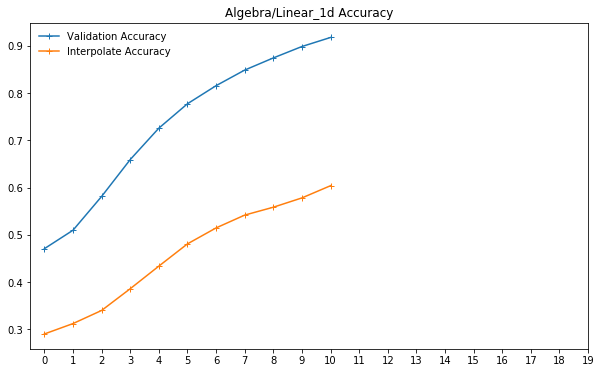

In [93]:
plt.rcParams['figure.figsize'] = [10, 6]

fig, ax = plt.subplots()

ax.plot(
    list(map(lambda l: l.step, valid_accuracy)),
    list(map(lambda l: l.value, valid_accuracy)),
    marker='+', label='Validation Accuracy'
)
ax.plot(
    list(map(lambda l: l.step, interpolate_accuracy)),
    list(map(lambda l: l.value, interpolate_accuracy)),
    marker='+', label='Interpolate Accuracy'
)
plt.title('Algebra/Linear_1d Accuracy')
ax.legend(loc='upper left', frameon=False)
plt.xticks(np.arange(0, 20, step=1.0))
plt.yticks(np.arange(0.3, 1.0, step=0.1))
plt.show()

> We see that in terms of validation, training reaches 94-95% on validation dataset and 60% for interpolate dataset.

## Single Prediction (the 5 best predictions)

In [14]:
model_process.predict_single(
    "what is 32 + 445?",
    model, device, n_best=5
)


[{'resp': '477', 'score': 0.0},
 {'resp': '577', 'score': -73.74555969238281},
 {'resp': '487', 'score': -76.30320739746094},
 {'resp': '467', 'score': -87.13648986816406},
 {'resp': '777', 'score': -112.008056640625}]

## Multiple Predictions

In [21]:
questions = [
    "what is 10 + 32?",
    "34 + 77?",
    "compute -23 + 129"
]

model_process.predict_multiple(questions, model, device)

[{'resp': '42', 'score': 0.0},
 {'resp': '111', 'score': 0.0},
 {'resp': '106', 'score': 0.0}]

### All your base are belong to 111

In [34]:
questions = [
    "What is 34 + 77",
    "What is 34 + 87",
]

print(model_process.predict_multiple(questions, model, device))

questions = [
    "What is 34 + 78",
    "What is 34 + 88",
]

print(model_process.predict_multiple(questions, model, device))

[{'resp': '111', 'score': 0.0}, {'resp': '111', 'score': 0.0}]
[{'resp': '112', 'score': 0.0}, {'resp': '122', 'score': 0.0}]


> Ok it still has a few weird issues :p

### Find the top worst cases

In [57]:
mdsmgr = MathDatasetManager(
  "/home/mandubian/datasets/mathematics_dataset/v1.0"
)

ds = mdsmgr.build_dataset_from_module('arithmetic', 'add_or_sub', 'train-easy')
print("size", len(ds))

ds_loader = data.DataLoader(
    ds, batch_size=128, shuffle=False, num_workers=4,
    collate_fn=question_answer_to_position_batch_collate_fn)


initialized MultiFilesMathDataset with categories ['algebra', 'numbers', 'polynomials', 'arithmetic', 'measurement', 'comparison', 'probability', 'calculus'] and types ['train-easy', 'train-medium', 'train-hard', 'interpolate', 'extrapolate']
size 666666


In [ ]:
import math_dataset
import collections

# Very unefficient Works case computer
worst_k = collections.deque(maxlen=10)    

def build_worst_k(batch_idx, all_hyp, all_scores):
    for i, idx_seqs in enumerate(all_hyp):
        r = math_dataset.np_decode_string(np.array(idx_seqs[0]))
        s = all_scores[i][0].cpu().item()
        if len(worst_k) == 0 or s < worst_k[0][2]:
            worst_k.appendleft((batch_idx + i, r, s))

model_process.predict_dataset(
    ds_loader, model, device,
    callback=build_worst_k,
    #max_batches=5
)


In [76]:

for (idx, r, s) in worst_k:
    q = ds[idx]["q"]
    a = ds[idx]["a"]
    print("-> question:", q)
    print("   predicted:", r, "(", a, ")")
    print("   solution:", a)
    print("   score", s)


-> question: What is 0.2 plus 0.1973?
   predicted: -5.0896 ( 0.3973 )
   solution: 0.3973
   score -1.60174560546875
-> question: What is -3.4 less than -2.9?
   predicted: 21.278 ( 0.5 )
   solution: 0.5
   score -1.5341033935546875
-> question: Put together 4 and 191647.
   predicted: -2.438 ( 191651 )
   solution: 191651
   score -1.3736724853515625
-> question: Put together 12193 and -7.
   predicted: -2155 ( 12186 )
   solution: 12186
   score -1.3134536743164062
-> question: -14649+2
   predicted: 2.754 ( -14647 )
   solution: -14647
   score -0.994903564453125
-> question: 2683+2
   predicted: 0.082 ( 2685 )
   solution: 2685
   score -0.789306640625
-> question: What is 209 - -0.8?
   predicted: 1146.84 ( 209.8 )
   solution: 209.8
   score -0.76519775390625
-> question: -9259432 + 1
   predicted: -63.5854 ( -9259431 )
   solution: -9259431
   score -0.63372802734375
-> question: -0.3 + 6703
   predicted: 904.269 ( 6702.7 )
   solution: 6702.7
   score -0.5973968505859375
-> q

As you can see, there are completely absurd answers like:

```
-0.3 + 6703 => 904.269  (should be 6702.7)
```

and others that aren't so far:

```
-99634 plus 98 => -99536 (should be -99536)
```

It's quite hard to know what our transformer learnt. Certainly, not the math laws, neither any abstraction but it can perform a lot of additions in 


### Check Transformer Model trained on arithmetic/add_or_sub/hard

In [98]:
exp_name = "math_ds_arithmetic_add_or_sub_hard"
unique_id = "20190423_1800"

#### Reload model

In [116]:
# build default transformer model
model = utils.build_transformer()
# restore model from checkpoint
_ = checkpoints.restore_best_checkpoint(exp_name, unique_id, "validation", model)


Extracting state from checkpoints/math_ds_arithmetic_add_or_sub_hard_20190423_1800_validation_best.pth
Loading model state_dict from state found in checkpoints/math_ds_arithmetic_add_or_sub_hard_20190423_1800_validation_best.pth


#### Plot accuracy evolution during training

In [96]:
valid_ea = tensorboard_event_accumulator(
    f"./runs/{exp_name}_{unique_id}_eval/events.out.tfevents.1556039027.c77692173f6a"
)

interpolate_ea = tensorboard_event_accumulator(
    f"./runs/{exp_name}_{unique_id}_interpolate/events.out.tfevents.1556039036.c77692173f6a"
)

valid_accuracy = valid_ea.Scalars("epoch/accuracy")
valid_loss_per_char = valid_ea.Scalars("epoch/loss_per_char")

interpolate_accuracy = interpolate_ea.Scalars("epoch/accuracy")
interpolate_loss_per_char = interpolate_ea.Scalars("epoch/loss_per_char")


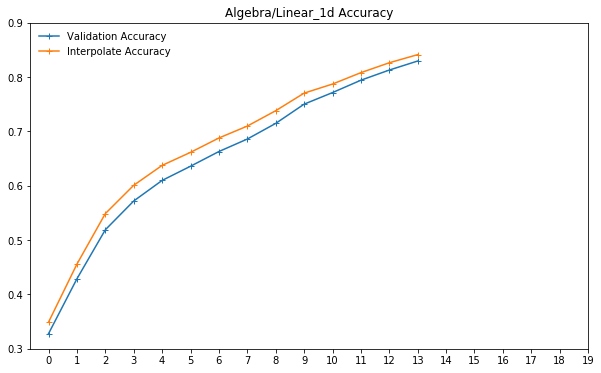

In [97]:
plt.rcParams['figure.figsize'] = [10, 6]

fig, ax = plt.subplots()

ax.plot(
    list(map(lambda l: l.step, valid_accuracy)),
    list(map(lambda l: l.value, valid_accuracy)),
    marker='+', label='Validation Accuracy'
)
ax.plot(
    list(map(lambda l: l.step, interpolate_accuracy)),
    list(map(lambda l: l.value, interpolate_accuracy)),
    marker='+', label='Interpolate Accuracy'
)
plt.title('Algebra/Linear_1d Accuracy')
ax.legend(loc='upper left', frameon=False)
plt.xticks(np.arange(0, 20, step=1.0))
plt.yticks(np.arange(0.3, 1.0, step=0.1))
plt.show()

Compared to model trainined Easy mode, it reaches 85% instead of 95% on validation dataset but it's much more efficient on interpolate dataset (almost same as validation dataset).

So it's much more able to manage diversity of interpolate dataset.

If we test on 

In [122]:
questions = [
    "-709581481585 - 0.144?"
]

print(model_process.predict_multiple(questions, model, device))
# solution is -709581481585.144

[{'resp': '-709581481585.144', 'score': 0.0}]


Hey, it's not bad, right?

Test it on very simple additions:

In [123]:
questions = [
    "What is 1 + 1",
    "What is 5 + 5",
]

print(model_process.predict_multiple(questions, model, device))

[{'resp': '11.3', 'score': -0.00078582763671875}, {'resp': '51.5', 'score': -0.08533477783203125}]


Not very good in simple additions :D

```
1 + 1 => 11.3
```


So, it's not really computing the additions, it's more about learning to associate characters together in a sequence.

So, it's not yet going to replace our little calculators or even our brains but is it possible to push our relational models (or other kinds of models) so far that it understands the laws of additions? That's the stake for my next experiments ;)


> Next Steps:
> - test funnier models
> - test extrapolate models
> - train skynet ;)